## Run a `GMM`-`AffineMode` model on the 9-12-removed dataset

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import scalar 
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util
from kpsn.models import pose
from kpsn.util import pca
from kpsn.util import keypt_io
from kpsn.util import alignment

import kpsn_test.visualize as viz

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Load data

In [15]:
metadata, keypts = keypt_io.npy_dataset("/n/groups/datta/kai/mph/data_explore/data")

# operate on a subset of the data without some redundancy
# since we don't care about dynamics anyway
keypts = keypt_io.subsample_time(keypts, 15)

# rotate subject to standard orientation
align_result = alignment.sagittal_align(keypts)
metadata, align_result = keypt_io.select_subset(metadata, align_result, [
    i_subj for i_subj in range(len(align_result))
    if (not metadata['age'][i_subj] in [9, 12])
])

gt_obs = pose.Observations(
    keypt_io.to_feats(util.computations.restack(align_result))[:, :12],
    util.computations.stack_ixs(align_result))

Reloading 'kpsn.fitting.em'.


[autoreload of kpsn.fitting.em failed: Traceback (most recent call last):
  File "/home/kaf200/miniconda3/envs/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 271, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/home/kaf200/miniconda3/envs/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/kaf200/miniconda3/envs/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/kaf200/miniconda3/envs/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/home/kaf200/miniconda3/envs/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment only supported for heap types or ModuleType subclasses
]


### Set up model

In [16]:
N = len(align_result)
M = gt_obs.keypts.shape[1]
eps = 0.05
morph_hyperparams = afm.AffineModeMorphHyperparams(
    N = N, M = M, L = 1,
    modes=None, update_scale = 0.3)
pose_hyperparams = gmm.GMMHyperparams(
    N = N, M = M, L = 5, eps = eps,
    pop_weight_uniformity = 10,
    subj_weight_uniformity = 100)
model = joint_model.JointModel(morph = afm.AffineModeMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

In [17]:
init_params = joint_model.init(
    model,
    hyperparams,
    gt_obs,
    reference_subject = 0,
    posespace_kws = dict(fit_to_all_subj = True)
)

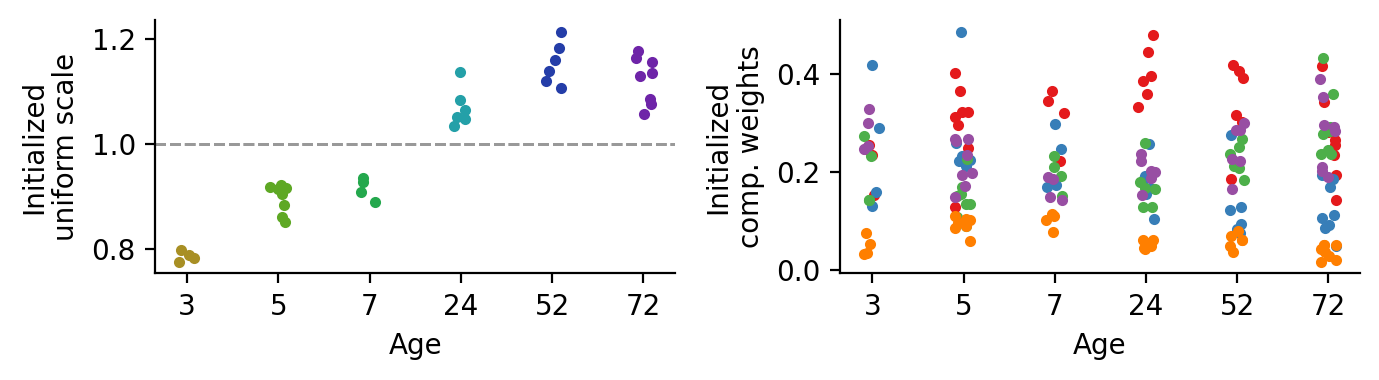

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (7, 2))

jitter = 0.1
ages, age_groups = keypt_io.get_groups(metadata, 'age')
age_pal = dict(zip(ages, sns.hls_palette(l = 0.4, n_colors = len(ages) + 2)[1:-1]))
comp_pal = sns.color_palette('Set1', hyperparams.posespace.L)

for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
    ax[0].axhline(1, ls = '--', color = '.6', lw = 1)
    ax[0].plot(
        np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
        jnp.exp(init_params.morph.uniform_scale()[age_group]),
        'o', ms = 3, color = age_pal[age])
    for i_comp in range(hyperparams.posespace.L):
        ax[1].plot(
            np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
            init_params.posespace.weights()[age_group, i_comp],
            'o', ms = 3, color = comp_pal[i_comp],
        )

for i in [0,1]: 
    ax[i].set_xticks(np.arange(len(ages)))
    ax[i].set_xticklabels(ages)
    ax[i].set_xlabel("Age")
ax[0].set_ylabel("Initialized\nuniform scale")
ax[1].set_ylabel("Initialized\ncomp. weights")
sns.despine()
plt.tight_layout()
plt.show()

### Fit model

In [19]:
loss_hist, fit_params, mstep_losses, param_hist, trace = em.iterate_em(
    model = model,
    init_params = init_params,
    emissions = gt_obs,
    hyperparams = hyperparams,
    n_steps = 10,
    log_every = 1,
    progress = True,
    tol = None,
    mstep_n_steps = 150,
    mstep_learning_rate = 2e-3,
    mstep_tol = 1e-7,
    mstep_stop_window = 25,
    batch_size = 30,
    return_mstep_losses = True,
    return_param_hist = True,
    return_reports = True
)

  0%|          | 0/10 [00:00<?, ?it/s]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)


 10%|█         | 1/10 [00:09<01:27,  9.74s/it]

Step 0 : loss = 4882.46728515625


 20%|██        | 2/10 [00:10<00:34,  4.25s/it]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 1 : loss = 4893.4501953125


 30%|███       | 3/10 [00:10<00:17,  2.52s/it]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 2 : loss = 4887.83544921875


 40%|████      | 4/10 [00:11<00:10,  1.71s/it]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 3 : loss = 4865.3515625


 50%|█████     | 5/10 [00:11<00:06,  1.24s/it]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 4 : loss = 4938.29150390625


 60%|██████    | 6/10 [00:11<00:03,  1.04it/s]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 5 : loss = 4813.93505859375


 70%|███████   | 7/10 [00:12<00:02,  1.23it/s]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 6 : loss = 4768.609375


 80%|████████  | 8/10 [00:12<00:01,  1.43it/s]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 7 : loss = 4901.32373046875


 90%|█████████ | 9/10 [00:13<00:00,  1.63it/s]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 8 : loss = 4844.40673828125


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

query_point (1080, 3) cov (1, 3, 3) cov_inv (1, 3, 3) A (1080, 3, 3) Ainv (1080, 3, 3) d (1080, 3)
Step 9 : loss = 4807.4482421875


In [ ]:
init_params